# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
### Owner: [Mayur Bhise](https://www.linkedin.com/in/mayur-bhise/)
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [3]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


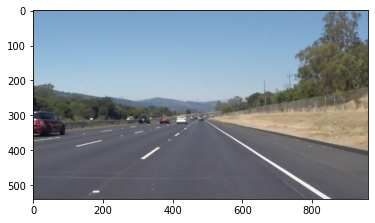

In [4]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images  
`cv2.cvtColor()` to grayscale or change color  
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Building a Solution Pipeline using Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

## Step 1: Convert the image to Grayscale
#### Convert the image from 3-channel RGB to 1-channel

In [5]:
import math

def grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

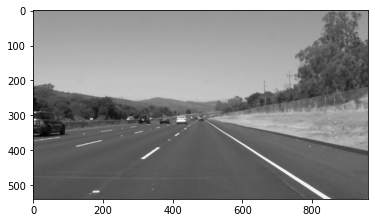

In [6]:
gray = grayscale(image)
plt.imshow(gray, cmap='gray')

## Step 2: Apply a Gaussian Noise Kernel
#### Gaussian blur: blur the image, get rid of the noise boundaries, elements because we're only interested in strong contrasting boundary lines.

In [7]:
def gaussian_blur(img, kernel_size = 5):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

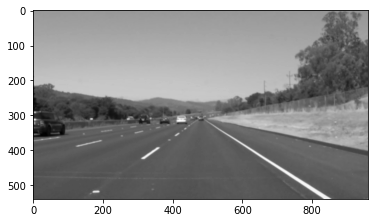

In [8]:
blur_gray = gaussian_blur(gray, kernel_size = 5)
plt.imshow(blur_gray, cmap='gray')

## Step 3: Apply Canny Transform
#### To help generate edges. For looking at the gradients, contrast. This just focuses on 1 channel.

In [9]:
def canny(image, low_threshold, high_threshold):
    return cv2.Canny(image, low_threshold, high_threshold)

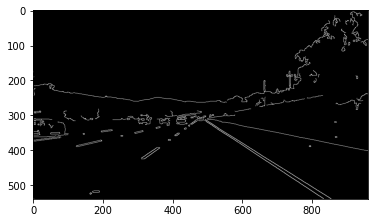

In [10]:
edges = canny(blur_gray, 50, 150)
plt.imshow(edges, cmap='gray')

### Step 4: Apply Regional Mask
#### Region of Interest: crop out areas which doesn't contain lane markers i.e., create a region around lane lines.

In [13]:
def region_of_interest(image):
    # Create a masked edges image using cv2.fillPoly()
    mask = np.zeros_like(image)
    # Define a four sided polygon to mask
    imshape = image.shape
    if len(imshape) > 2:
        channel_count = imshape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
    vertices = np.array([[(0,imshape[0]),(500, 320), (490, 320), (imshape[1],imshape[0])]], dtype=np.int32)
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    return cv2.bitwise_and(image, mask)

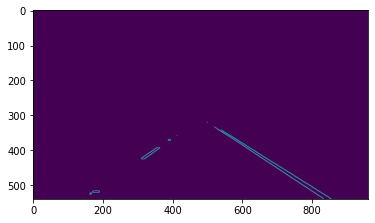

In [14]:
masked_edges = region_of_interest(edges)
plt.imshow(masked_edges)

## Step 5: Apply Hough Transform
#### Hough Transform: a popular technique to detcet any shape, if you can represent that shape in mathematical form. 
#### For more, visit: https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_houghlines/py_houghlines.html

In [15]:
def hough(image):
    rho = 2                         # distance resolution in pixels of the Hough grid
    theta = np.pi/180               # angular resolution in radians of the Hough grid
    threshold = 19                  # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 24            # minimum number of pixels making up a line
    max_line_gap = 20               # maximum gap in pixels between connectable line segments
    # Run Hough on edge detected image. Output is an array containing endpoints of detected line segments.
    return cv2.HoughLinesP(image, rho, theta, threshold, np.array([]),min_line_length, max_line_gap)

In [16]:
lines = hough(masked_edges)
print(*lines)

[[538 342 853 538]] [[630 406 832 538]] [[554 355 620 398]] [[319 425 362 394]] [[613 389 853 539]] [[310 423 356 392]] [[498 320 545 351]] [[615 396 673 433]] [[522 335 547 352]] [[318 425 363 392]] [[520 334 772 498]] [[794 514 830 537]] [[329 409 355 392]]


## Step 6: Draw Left & Right Lines
#### Draw left and right lane lines by averaging/extrapolating the lines obtained using the helper functions from the sections above.

In [18]:
def draw_lanes(lines, image):
    
    lane_image = np.copy(image)*0 #creating a blank to draw lines on
    lane_color = (0,0,255)
    lane_thickness = 10
    
    left_slopes = []
    left_intercepts = []
    
    right_slopes = []
    right_intercepts = []
    
    y_max = image.shape[0]
    y_min = lane_image.shape[0]
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            m, b = np.polyfit((x1, x2), (y1, y2), 1)
            y_min = min(y_min, y1, y2)
            if(m > 0):
                left_slopes.append(m)
                left_intercepts.append(b)
            if(m < 0):
                right_slopes.append(m)
                right_intercepts.append(b)
                
    if len(left_slopes) > 0: 
        # Draw the left lane
        left_slope = np.median(left_slopes)
        left_intercept = np.median(left_intercepts)
        left_x_min = int((y_min-left_intercept)/left_slope)
        left_x_max = int((y_max-left_intercept)/left_slope)
        cv2.line(lane_image, (left_x_min, y_min), (left_x_max, y_max), lane_color, lane_thickness)
    if len(right_slopes) > 0:
        # Draw the right lane
        right_slope = np.median(right_slopes)
        right_intercept = np.median(right_intercepts)
        right_x_min = int((y_min-right_intercept)/right_slope)
        right_x_max = int((y_max-right_intercept)/right_slope)
        cv2.line(lane_image, (right_x_min, y_min), (right_x_max, y_max), lane_color, lane_thickness)
    
    return cv2.addWeighted(image, 0.8, lane_image, 1, 0)

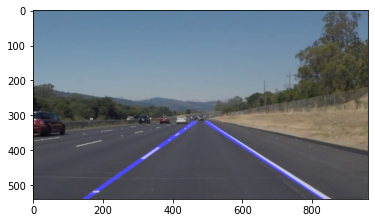

In [22]:
lanes = draw_lanes(lines, image)
plt.imshow(lanes)

## Final Solution Pipeline

In [20]:
def pipeline(image):
    gray = grayscale(image)
    blur_gray = gaussian_blur(gray, kernel_size = 5)
    edges = canny(blur_gray, 50, 150)
    masked_edges = region_of_interest(edges)
    lines = hough(masked_edges)
    
    return draw_lanes(lines, image)

## Testing the solution pipeline on the test images

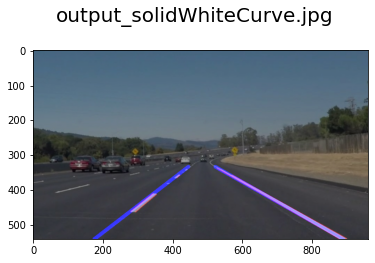

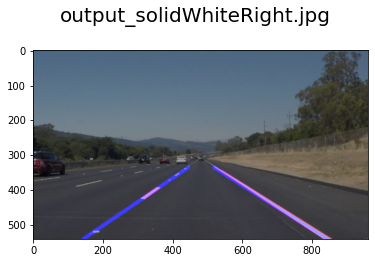

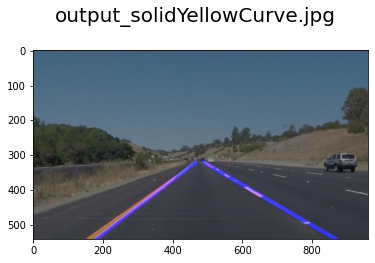

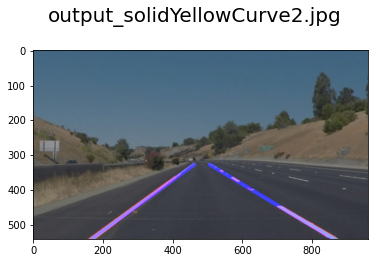

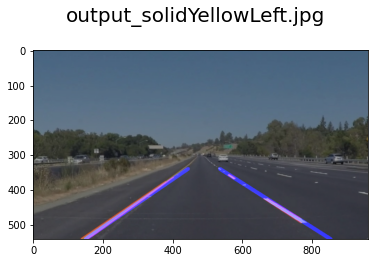

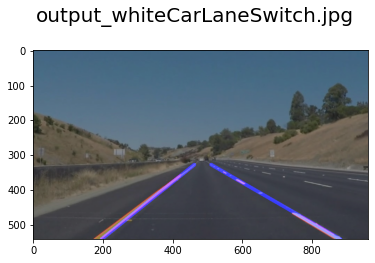

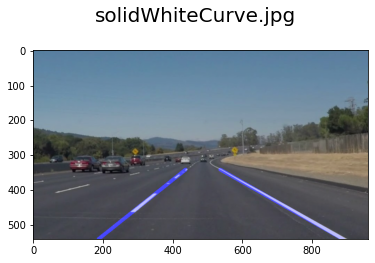

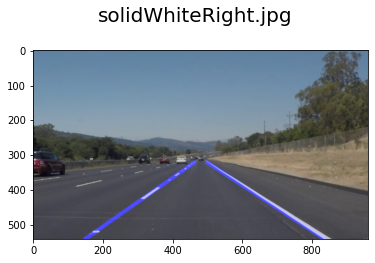

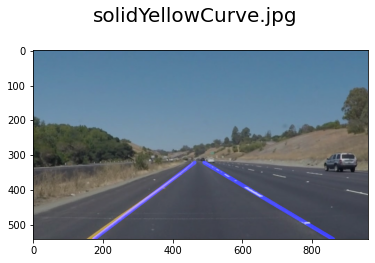

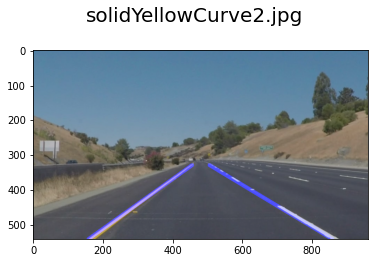

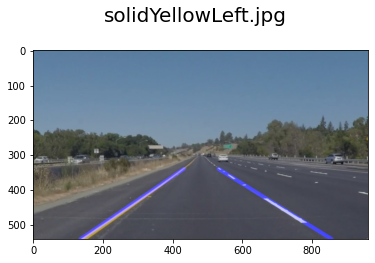

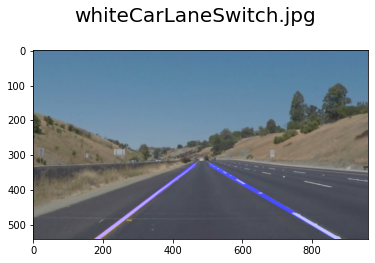

In [23]:
import os

test_images = os.listdir("test_images/")

if not os.path.isdir("results"):
    os.mkdir("results")

for i in range(0, len(test_images)):
    # Read image
    img = mpimg.imread(os.path.join("test_images", test_images[i]))
    # Run the pipeline
    img_out = pipeline(img)
    # Save output
    mpimg.imsave(os.path.join("results", test_images[i]), img_out)
    # Show output
    plt.figure()
    plt.suptitle(test_images[i], fontsize=20)
    plt.imshow(img_out)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [24]:
import os
os.listdir("test_images/")

['output_solidWhiteCurve.jpg',
 'output_solidWhiteRight.jpg',
 'output_solidYellowCurve.jpg',
 'output_solidYellowCurve2.jpg',
 'output_solidYellowLeft.jpg',
 'output_whiteCarLaneSwitch.jpg',
 'solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

#### NOTE: This section includes the output of test images obtained by detecting the line segments before connecting/averaging/extrapolating them.

In [27]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images_output directory.

import os
files = os.listdir("test_images/")

for file in files:
    if file[0:6] != "output":
        img = mpimg.imread("test_images/"+file)
        # Gray scale
        gray = grayscale(img)
        # Gaussian blur: blur the image, get rid of the noise elements 
        # because we're only interested in strong contrasting boundary lines
        gray = gaussian_blur(gray,3)
        
        # Canny Trasform to help generate edges
        edges = canny(gray,50,150)
        
        # Region of Interest: crop out areas which doesn't contain
        # lane markers i.e., create a region around lane lines
        imshape = img.shape
        vertices = np.array([[(.51*imshape[1], imshape[0]*.58),(.49*imshape[1], imshape[0]*.58), (0, imshape[0]), (imshape[1], imshape[0])]], dtype=np.int32)
        target = region_of_interest(edges)
        
        # Hough Transform: apopular technique to detcet any shape,
        # if you can represent that shape in mathematical form.
        # For more, visit: https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_houghlines/py_houghlines.html
        lines = hough(target,1,np.pi/180,35,5,2)
        
        # Weighted Image
        result = weighted_img(lines,img,α=0.8, β=1.0)
        
        plt.imshow(result, cmap='gray')
        
        r,g,b = cv2.split(result)
        result = cv2.merge((b,g,r))
        
        ##result = gray
        ##result = lines
        ##result = target
    
        # do some modifications to the image and save them off to the folder
        cv2.imwrite("test_images/output_"+file, result)
        ##plt.imshow(result, cmap='gray')
        

TypeError: hough() takes 1 positional argument but 6 were given

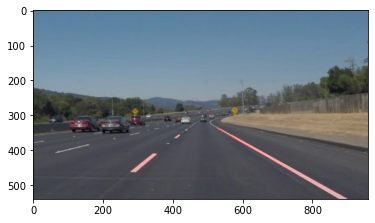

In [50]:
image1 = mpimg.imread('test_images/output_solidWhiteCurve.jpg')
#printing out some stats and plotting
plt.imshow(image1)

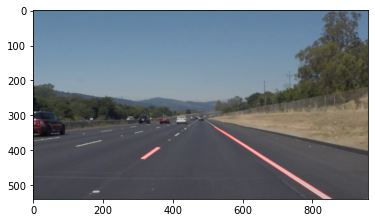

In [51]:
image2 = mpimg.imread('test_images/output_solidWhiteRight.jpg')
#printing out some stats and plotting
plt.imshow(image2)

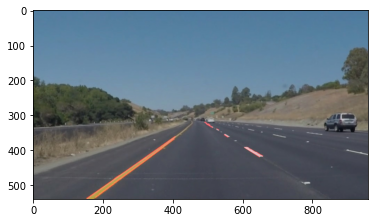

In [52]:
image3 = mpimg.imread('test_images/output_solidYellowCurve.jpg')
#printing out some stats and plotting
plt.imshow(image3)

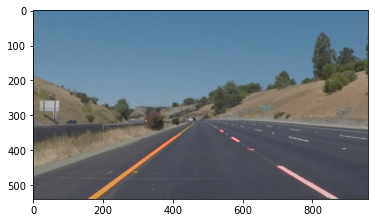

In [53]:
image4 = mpimg.imread('test_images/output_solidYellowCurve2.jpg')
#printing out some stats and plotting
plt.imshow(image4)

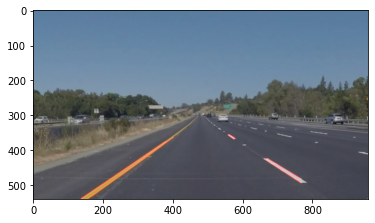

In [54]:
image5 = mpimg.imread('test_images/output_solidYellowLeft.jpg')
#printing out some stats and plotting
plt.imshow(image5)

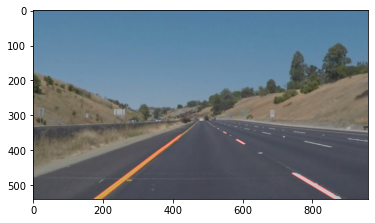

In [55]:
image6 = mpimg.imread('test_images/output_whiteCarLaneSwitch.jpg')
#printing out some stats and plotting
plt.imshow(image6)

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [28]:
# Import everything needed to edit/save/watch video clips
!pip install moviepy
from moviepy.editor import VideoFileClip
from IPython.display import HTML

     -------------------------------------- 388.3/388.3 KB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached requests-2.28.1-py3-none-any.whl (62 kB)
     ---------------------------------------- 3.4/3.4 MB 6.7 MB/s eta 0:00:00
     --------------------------------------- 22.6/22.6 MB 10.6 MB/s eta 0:00:00
     ------------------------------------- 160.2/160.2 KB 10.0 MB/s eta 0:00:00
     -------------------------------------- 139.9/139.9 KB 8.1 MB/s eta 0:00:00
  Using cached charset_normalizer-2.1.0-py3-none-any.whl (39 kB)
  Using cached idna-3.3-py3-none-any.whl (61 kB)
Using legacy 'setup.py install' for moviepy, since package 'wheel' is not installed.
  Attempting uninstall: decorator
    Found existing installation: decorator 5.1.1
    Uninstalling decorator-5.1.1:
      Successfully uninstalled decorator-5.1.1
  Running setup.py install for moviepy: started
  Running setup.py install for mo

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
You should consider upgrading via the 'C:\Users\mayur\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.


Let's try the one with the solid white lane on the right first ...

In [35]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
#%time white_clip.write_videofile(white_output, audio=False)

Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [33]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

NOTE: This section is already included in the earlier section using the **draw_lanes(lines, image)** function.

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [36]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(pipeline)
%time yellow_clip.write_videofile(yellow_output, audio=False)

Moviepy - Building video test_videos_output/solidYellowLeft.mp4.
MoviePy - Writing audio in solidYellowLeftTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video test_videos_output/solidYellowLeft.mp4



TypeError: must be real number, not NoneType

In [37]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

#### When I used the solution pipeline (the one without extraplotaing the lines), the edge of the road divider is being detected as a lane and is causing confusion. There are also distortions where parts of certain objects such as trees are detected in the video output. Considering the project dealine, I'd be glad to explore more on opencv and tuning the hyperparameters to make it more robust in the future.

In [39]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(pipeline)
%time challenge_clip.write_videofile(challenge_output, audio=False)

Moviepy - Building video test_videos_output/challenge.mp4.
MoviePy - Writing audio in challengeTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video test_videos_output/challenge.mp4



TypeError: must be real number, not NoneType

In [40]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

## Observations

#### Potentail shortcomings:
- What if the camera position is changed or the lane lines are relatively obscured? The algorithm fails to detect the lane lines (Ex: Optional Challenge video).
- Region of Interest: Currently it's quite coupled to the vision area shown in the test images. We have defined a region of interest in the code above. That is specific to how camera is mounted on the car. Slight changes in how the camera is mounted could lead to error or other features on the road to be detected as lane lines.
- What if there are other vehicles or objects within the region of interest? This raises a suspicion that some features of those cars can be detected as lane lines and cause confusion.  
- This project is intended to only detect (mostly) straight lines. A possible improvement would be to modify the above pipeline to detect curved lane line.  
- Given the scope of the project, we haven't explored the lane detection while changing the lanes which is a huge challenge.
- [Salt Sprayed Roads Confuse Autopilot](https://www.reddit.com/r/teslamotors/comments/5z7bft/a_new_edge_case_for_tesla_salt_sprayed_roads/): This is an interesting thread of discussion on a particular edge case involving lane detection.  
- What would happen when the image has brighter and darker zones, for example different asphalt colours or shadows? This would make the algorithm miss lane lines and potentionally detect incorrect lines, generating lots of clutter.  

#### Possible improvements:
- Test the above pipeline on roads with diverse weather conditions and time including, but not limited to, rain, snow, night.  
- To detect the edges in all colour channels and then apply the Hough transform. This could help avoiding problems caused by the color changes or brightness.
- To use a more complex region of interest which would fit to different road shapes other than the usual and clean ones.

## References & Acknowledgement:  
- Calculating the slope and center for averaging/extrapolation of the Hough lines: [Demo video with Q&A session](https://www.youtube.com/watch?v=hnXkCiM2RSg&feature=youtu.be) by David Silver, Head of Self-Driving Cars at Udacity; [Blogpost on Simple Lane Detection with OpenCV](https://medium.com/@mrhwick/simple-lane-detection-with-opencv-bfeb6ae54ec0).  
- Hough Transformation Lane Detection: The OpneCV Turorial on [Hough Line Transform](https://docs.opencv.org/2.4/doc/tutorials/imgproc/imgtrans/hough_lines/hough_lines.html) has greatly helped me with the understanding and working of hough lines.  
- Other relevant sources: [OpenCV Python Tutorial - Find Lanes for Self-Driving Cars](https://www.youtube.com/watch?v=eLTLtUVuuy4), [Medium](http://medium.com/), [OpenCV Tutorials](https://docs.opencv.org/master/d9/df8/tutorial_root.html).  
- Stackoverflow and Stackexchange: The expert community groups and channels under [Stack Overflow](https://stackoverflow.com/) and [Stack Exchange](https://stackexchange.com/) has greatly helped me with optimal use of functions and debugging the code.  